# Analyzing New York City employees' payroll database 

## Data Source: [NYC open data](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e/data)

In [1]:
import pandas as pd
df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.lower()
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df.shape

(2864545, 17)

Previous versions of the dataset didn't import all the years correctly, so I'll do these sanity checks a couple of times

In [3]:
df.fiscal_year.value_counts()

2019    592431
2020    590210
2021    573477
2017    562266
2018    546161
Name: fiscal_year, dtype: int64

#### Cleaning the data

The database includes people whose work locations are outside of NYC. For this analyses, I'm only including employees with work locations in NYC boroughs. Since Staten Island wasn't listed (unless included in the "other" location, this is filtered down to Queens, Manhattan, Bronx and Brooklyn.

In [4]:
boroughs = ['QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']

In [5]:
df = df[df.work_location_borough.isin(boroughs)]

In [6]:
df.shape

(2760682, 17)

Note: This reduced the dataset by 103,863 rows.

### A note on the assumptions I'm making here on:

From our reporting, I found that some employees tend to work more overtime as they get closer to retirement. Let's take a closer look here on.

In [7]:
df['agency_start_date'] = pd.to_datetime(df.agency_start_date, errors='coerce')
df['today'] = pd.to_datetime('today')
df['tenure_years'] = (df.today - df.agency_start_date).astype('timedelta64[Y]')

In [8]:
df

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
0,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARON,TERESA,NaN,2016-03-21,BRONX,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,825.00","51,709.59",588.00,"22,374.31",639.66,2022-05-07 19:53:35.599866,6.00
1,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARONS,CAMELIA,M,2016-08-08,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,595.55","41,960.18",121.75,"3,892.19",108.25,2022-05-07 19:53:35.599866,5.00
2,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL,MODUPE,NaN,2008-02-11,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","56,298.93",54.75,"2,455.88","3,938.75",2022-05-07 19:53:35.599866,14.00
3,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL RAHMAN,ABDUL AZIZ,I,2014-10-20,MANHATTAN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","55,346.09",273.00,"11,069.41","1,124.51",2022-05-07 19:53:35.599866,7.00
4,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDULGANIYU,MONSURAT,A,2013-02-04,BRONX,JUVENILE COUNSELOR,ACTIVE,"44,409.00",per Annum,"1,762.00","44,157.49",815.50,"27,878.15","2,019.34",2022-05-07 19:53:35.599866,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864536,2021,745.00,DEPT OF ED HRLY SUPPORT STAFF,FRATIANNI,MARYANN,C,1999-04-27,MANHATTAN,F/T SCHOOL AIDE,CEASED,17.00,per Hour,0.00,"-57,256.00",0.00,0.00,"5,814.70",2022-05-07 19:53:35.599866,23.00
2864537,2021,742.00,DEPT OF ED PEDAGOGICAL,LAMBERT,MARISA,M,2005-09-06,MANHATTAN,ASSISTANT PRINCIPAL,ON LEAVE,"130,351.00",per Annum,0.00,"-36,364.44",0.00,0.00,"-15,369.52",2022-05-07 19:53:35.599866,16.00
2864538,2021,745.00,DEPT OF ED HRLY SUPPORT STAFF,RIVERA,SARAH,M,1997-09-02,MANHATTAN,F/T SCHOOL AIDE,CEASED,17.04,per Hour,0.00,"-58,284.17",0.00,0.00,"4,347.24",2022-05-07 19:53:35.599866,24.00
2864541,2021,902.00,BRONX DISTRICT ATTORNEY,SIMMONS,NATHANIEL,NaN,1990-07-02,BRONX,SPECIAL ASSISTANT TO THE DISTRICT ATTORNEY,CEASED,"110,000.00",per Annum,-70.00,"-4,207.65",0.00,0.00,"-75,440.00",2022-05-07 19:53:35.599866,31.00


In [10]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df # .query("agency_name=='DEPARTMENT OF CORRECTION'")

# title_description
# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ regular_hours + tenure_years', data=to_model) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                 6.880e+05
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        19:54:21   Log-Likelihood:            -1.7350e+07
No. Observations:             2760380   AIC:                         3.470e+07
Df Residuals:                 2760377   BIC:                         3.470e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -14.5109      0.151    -96.040      0.000     -14.807     -14.215
regular_hours     0.1034   8.82e-05   1171.919      0.000       0.103       0.104
tenure_years      0.5045      0.008     61.266      0.000       0.488       0.521
==============================================================================
Omnibus:                  1872011.420   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         45045085.501
Skew:                           2.940   Prob(JB):                         0.00
Kurtosis:                      21.896   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ValueError: Length of values (2760380) does not match length of index (2760682)

In [ ]:
df.total_ot_paid.max()

In [ ]:
df.total_ot_paid.min().round()

In [ ]:
df.query('total_ot_paid == 248749.72')

In [ ]:
df['total_pay'] = df.regular_gross_paid + df.total_ot_paid + df.total_other_pay

In [11]:
df.query('total_ot_paid == 248749.72')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
2291076,2021,996.00,NYC HOUSING AUTHORITY,PROCIDA,ROBERT,NaN,1987-04-13,BRONX,SUPERVISOR PLUMBER,ACTIVE,387.03,per Day,"1,820.00","100,627.80","2,249.50","248,749.72","7,215.34",2022-05-07 19:53:35.599866,35.00


In [12]:
df.groupby(by='agency_name').total_ot_paid.sum().reset_index().sort_values(by='total_ot_paid', ascending=False).head(5)

,agency_name,total_ot_paid
125,POLICE DEPARTMENT,"3,410,660,240.39"
88,FIRE DEPARTMENT,"1,596,842,055.03"
59,DEPARTMENT OF CORRECTION,"981,672,183.09"
65,DEPARTMENT OF SANITATION,"790,873,824.62"
114,NYC HOUSING AUTHORITY,"553,297,085.88"


In [13]:
df.agency_name.value_counts().reset_index().head(20)

,index,agency_name
0,DEPT OF ED PEDAGOGICAL,494409
1,DEPT OF ED PER SESSION TEACHER,466518
2,POLICE DEPARTMENT,292030
3,DEPT OF ED PARA PROFESSIONALS,192268
4,BOARD OF ELECTION POLL WORKERS,183495
5,DEPT OF ED HRLY SUPPORT STAFF,107844
6,FIRE DEPARTMENT,89030
7,DEPARTMENT OF EDUCATION ADMIN,80150
8,HRA/DEPT OF SOCIAL SERVICES,70396
9,DEPT OF PARKS & RECREATION,68053


In [14]:
df.query('agency_name == "DEPARTMENT OF CORRECTION"')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
91106,2017,NaN,DEPARTMENT OF CORRECTION,AARON,SHELLON,NaN,2010-12-16,QUEENS,CORRECTION OFFICER,ACTIVE,"82,808.00",per Annum,"1,970.02","78,954.24",599.52,"43,311.50","14,064.12",2022-05-07 19:53:35.599866,11.00
91107,2017,NaN,DEPARTMENT OF CORRECTION,AAYAN,IBRAHIM,NaN,2016-06-27,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,"2,085.72","42,209.08",411.75,"12,887.34","2,951.43",2022-05-07 19:53:35.599866,5.00
91108,2017,NaN,DEPARTMENT OF CORRECTION,ABASI,JUSTIN,NaN,2017-06-19,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,74.28,825.46,0.00,0.00,0.00,2022-05-07 19:53:35.599866,4.00
91109,2017,NaN,DEPARTMENT OF CORRECTION,ABBASI,MONI,NaN,2013-11-18,QUEENS,THERMOSTAT REPAIRER,ACTIVE,368.08,per Day,"1,825.00","99,381.60",927.00,"98,482.83",788.74,2022-05-07 19:53:35.599866,8.00
91110,2017,NaN,DEPARTMENT OF CORRECTION,ABBATE,ANTHONY,NaN,2005-11-21,QUEENS,CEMENT MASON,CEASED,303.59,per Day,0.00,"1,064.00",0.00,0.00,0.00,2022-05-07 19:53:35.599866,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864434,2021,72.00,DEPARTMENT OF CORRECTION,ALBALADEJO,ELISA,P,2005-06-02,QUEENS,CORRECTION OFFICER,CEASED,"87,211.00",per Annum,-32.00,-411.44,0.00,0.00,"-12,782.15",2022-05-07 19:53:35.599866,16.00
2864445,2021,72.00,DEPARTMENT OF CORRECTION,JAMES,VENESSA,NaN,1999-04-01,QUEENS,CORRECTION OFFICER,CEASED,"87,211.00",per Annum,0.00,0.00,0.00,0.00,"-14,705.18",2022-05-07 19:53:35.599866,23.00
2864448,2021,72.00,DEPARTMENT OF CORRECTION,SIMPSON,QUINSEY,G,2002-06-06,QUEENS,CORRECTION OFFICER,CEASED,"89,391.00",per Annum,-80.00,"-1,106.68",0.00,802.98,"-14,661.14",2022-05-07 19:53:35.599866,19.00
2864493,2021,72.00,DEPARTMENT OF CORRECTION,HARRIS,CHARLES,A,2005-11-03,QUEENS,CAPTAIN,CEASED,"109,360.00",per Annum,-56.00,"-2,927.19",0.00,0.00,"-18,831.37",2022-05-07 19:53:35.599866,16.00


In [17]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df # .query("agency_name=='DEPARTMENT OF CORRECTION'")

# title_description
# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ regular_hours + tenure_years', data=to_model.query("agency_name=='DEPARTMENT OF CORRECTION'")) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.query("agency_name=='DEPARTMENT OF CORRECTION'").assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     6963.
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        19:55:36   Log-Likelihood:            -4.7632e+05
No. Observations:               67749   AIC:                         9.526e+05
Df Residuals:                   67746   BIC:                         9.527e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -105.1629      3.453    -30.454      0.000    -111.931     -98.395
regular_hours     0.1954      0.002    113.134      0.000       0.192       0.199
tenure_years      3.2986      0.131     25.161      0.000       3.042       3.556
==============================================================================
Omnibus:                    18752.083   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58865.682
Skew:                           1.421   Prob(JB):                         0.00
Kurtosis:                       6.575   Cond. No.                     6.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

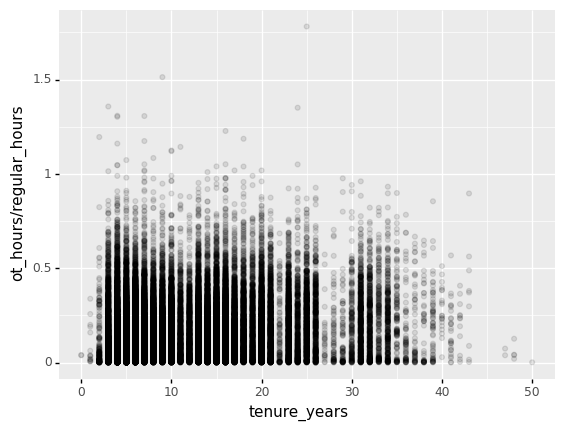

<ggplot: (351391321)>

In [21]:
from plotnine import *
(
    ggplot(to_model.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)    

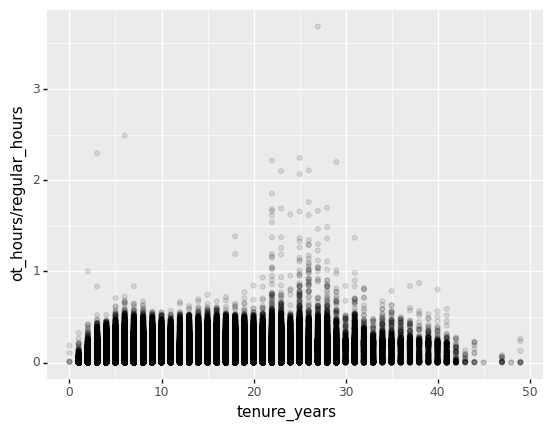

<ggplot: (351843313)>

In [22]:
(
    ggplot(to_model.query("agency_name=='POLICE DEPARTMENT'").query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


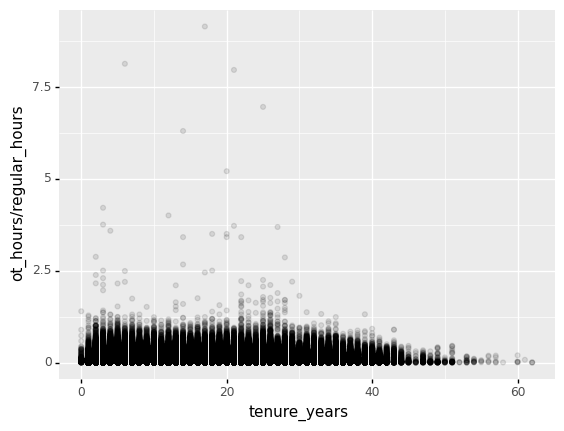

<ggplot: (390251872)>

In [23]:
(
    ggplot(to_model.query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)    

In [24]:
df.query('ot_hours/regular_hours > 5')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
74907,2017,NaN,COMMUNITY COLLEGE (MANHATTAN),GARAY,LUIS,NaN,2009-02-02,MANHATTAN,COLLEGE ASSISTANT,ACTIVE,12.00,per Hour,0.00,0.00,5.00,60.00,5.47,2022-05-07 19:53:35.599866,13.00
437032,2017,NaN,FIRE DEPARTMENT,BURKE,WILLIAM,O,1986-01-09,BROOKLYN,FIREFIGHTER,CEASED,"82,808.00",per Annum,0.00,"28,528.21",15.00,"5,510.90","2,609.71",2022-05-07 19:53:35.599866,36.00
452293,2017,NaN,FIRE DEPARTMENT,TUCKER,ROBERT,K,1994-10-23,BROOKLYN,FIREFIGHTER,CEASED,"82,808.00",per Annum,0.00,"22,229.02",9.00,"1,757.44","-1,129.45",2022-05-07 19:53:35.599866,27.00
529945,2017,NaN,POLICE DEPARTMENT,KUNDU,GOUTAM,NaN,2016-07-25,MANHATTAN,TRAFFIC ENFORCEMENT AGENT,CEASED,"30,706.00",per Annum,0.00,"-1,143.47",12.00,264.71,185.52,2022-05-07 19:53:35.599866,5.00
558886,2017,NaN,POLICE DEPARTMENT,WALDRON,MICHAEL,G,2015-01-07,MANHATTAN,POLICE OFFICER,CEASED,"44,521.00",per Annum,0.00,"3,261.94",0.67,296.05,"1,468.83",2022-05-07 19:53:35.599866,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861544,2021,740.00,DEPARTMENT OF EDUCATION ADMIN,TRAHAN,SHAMIKA,E,2019-06-16,QUEENS,CUSTOMER INFORMATION REPRESENTATIVE MA L 1549,CEASED,"40,345.00",per Annum,0.00,-771.60,0.50,11.04,760.56,2022-05-07 19:53:35.599866,2.00
2861667,2021,841.00,DEPARTMENT OF TRANSPORTATION,MCCARTHY,DAVID,M,1988-08-29,QUEENS,AREA SUPERVISOR,CEASED,"114,869.00",per Annum,0.00,0.00,13.50,"1,123.57","-1,123.57",2022-05-07 19:53:35.599866,33.00
2861939,2021,56.00,POLICE DEPARTMENT,RIVERA JR,DAVID,NaN,2020-03-23,MANHATTAN,CITY CUSTODIAL ASSISTANT,CEASED,"32,260.00",per Annum,0.00,-23.13,2.50,20.86,0.00,2022-05-07 19:53:35.599866,2.00
2862081,2021,56.00,POLICE DEPARTMENT,GIBSON,JEREMIAH,E,2020-03-24,MANHATTAN,CITY CUSTODIAL ASSISTANT,CEASED,"32,260.00",per Annum,0.00,0.00,2.50,20.86,-30.90,2022-05-07 19:53:35.599866,2.00


In [25]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
93697,2017,NaN,DEPARTMENT OF CORRECTION,COBBINAH,FELIX,NaN,2017-05-30,BRONX,MARINE ENGINEER,ACTIVE,36.19,per Hour,135.50,"2,587.94",176.50,"5,450.32",0.00,2022-05-07 19:53:35.599866,4.00
614082,2018,72.00,DEPARTMENT OF CORRECTION,CHIN,RAWLE,C,2014-05-19,BRONX,MARINE OILER,ACTIVE,29.24,per Hour,"1,490.00","45,146.56","1,749.50","97,787.38",523.46,2022-05-07 19:53:35.599866,7.00
615946,2018,72.00,DEPARTMENT OF CORRECTION,COBBINAH,FELIX,NaN,2017-05-30,BRONX,MARINE ENGINEER,CEASED,36.19,per Hour,519.12,"21,105.89",543.25,"35,201.16",903.68,2022-05-07 19:53:35.599866,4.00
627404,2018,72.00,DEPARTMENT OF CORRECTION,DOUGHERTY,TIMOTHY,R,2018-03-19,QUEENS,MARINE ENGINEER,ACTIVE,36.20,per Hour,416.00,"15,059.20",435.00,"24,568.80",451.84,2022-05-07 19:53:35.599866,4.00
1162273,2019,72.00,DEPARTMENT OF CORRECTION,FITZMAURICE,DANIEL,NaN,2016-08-22,QUEENS,PLASTERER,ACTIVE,358.56,per Day,"1,824.97","93,223.89","1,958.50","189,371.03",0.00,2022-05-07 19:53:35.599866,5.00
1162767,2019,72.00,DEPARTMENT OF CORRECTION,CHIN,RAWLE,C,2014-05-19,BRONX,MARINE OILER,ACTIVE,34.52,per Hour,"1,646.78","69,349.66","1,678.25","87,317.51","4,129.62",2022-05-07 19:53:35.599866,7.00
1811427,2020,72.00,DEPARTMENT OF CORRECTION,MALCOLM,OMAR,T,2012-09-06,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","3,147.00","127,375.43","13,559.40",2022-05-07 19:53:35.599866,9.00
1811463,2020,72.00,DEPARTMENT OF CORRECTION,FOO,AINSWORTH,K,2004-08-12,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","2,118.50","96,209.69","18,323.60",2022-05-07 19:53:35.599866,17.00
1811574,2020,72.00,DEPARTMENT OF CORRECTION,DAVIS,QURAAN,NaN,2011-08-25,BROOKLYN,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"2,080.00","84,831.14","2,338.02","95,080.59","12,269.04",2022-05-07 19:53:35.599866,10.00
1811793,2020,72.00,DEPARTMENT OF CORRECTION,DOUGHERTY,TIMOTHY,R,2018-03-19,QUEENS,MARINE ENGINEER,ACTIVE,37.65,per Hour,"1,594.00","60,014.10","1,849.75","104,473.88","2,711.04",2022-05-07 19:53:35.599866,4.00


In [26]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1'))

34

In [33]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.max()

25.0

In [34]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.min()

2.0

In [36]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').sort_values(by='tenure_years', ascending=False)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
2638586,2021,72.00,DEPARTMENT OF CORRECTION,HOWARD,PATRICIA,NaN,1996-07-01,MANHATTAN,CORRECTION OFFICER,CEASED,"80,788.00",per Annum,32.00,"1,221.04",57.00,"1,923.92","16,202.09",2022-05-07 19:53:35.599866,25.00
2291089,2021,72.00,DEPARTMENT OF CORRECTION,GIVES,DEMETRIA,NaN,1997-10-23,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,809.50","162,012.85","24,946.87",2022-05-07 19:53:35.599866,24.00
2291383,2021,72.00,DEPARTMENT OF CORRECTION,BARNABY,MELVIN,NaN,1997-07-10,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","112,852.33","2,184.50","104,544.07","22,407.12",2022-05-07 19:53:35.599866,24.00
2295144,2021,72.00,DEPARTMENT OF CORRECTION,JAMES,TERRANCE,NaN,2001-06-07,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,118.00","81,470.45","21,591.93",2022-05-07 19:53:35.599866,20.00
2291222,2021,72.00,DEPARTMENT OF CORRECTION,MASSEY-COVINGTO,DARLENE,E,2004-03-04,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,161.00","111,907.50","19,537.03",2022-05-07 19:53:35.599866,18.00
2293891,2021,72.00,DEPARTMENT OF CORRECTION,IP,KENNY,C,2004-02-12,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,467.03","94,632.39","16,524.24",2022-05-07 19:53:35.599866,18.00
1811463,2020,72.00,DEPARTMENT OF CORRECTION,FOO,AINSWORTH,K,2004-08-12,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","2,118.50","96,209.69","18,323.60",2022-05-07 19:53:35.599866,17.00
2297787,2021,72.00,DEPARTMENT OF CORRECTION,MATURA,ILYA,V,2005-12-27,BRONX,MARINE ENGINEER,ACTIVE,"64,231.00",per Annum,"1,664.00","64,050.10","2,042.50","115,360.40","3,614.72",2022-05-07 19:53:35.599866,16.00
2291281,2021,72.00,DEPARTMENT OF CORRECTION,BLACKWOOD,CARLOS,NaN,2005-06-09,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","113,582.67","2,186.25","123,996.94","12,267.56",2022-05-07 19:53:35.599866,16.00
2295466,2021,72.00,DEPARTMENT OF CORRECTION,DUPAL,LORRAINE,NaN,2006-11-09,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,162.57","92,188.62","9,557.41",2022-05-07 19:53:35.599866,15.00


In [38]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1000').sort_values(by='ot_hours', ascending=False)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
1811427,2020,72.00,DEPARTMENT OF CORRECTION,MALCOLM,OMAR,T,2012-09-06,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","3,147.00","127,375.43","13,559.40",2022-05-07 19:53:35.599866,9.00
2291089,2021,72.00,DEPARTMENT OF CORRECTION,GIVES,DEMETRIA,NaN,1997-10-23,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,809.50","162,012.85","24,946.87",2022-05-07 19:53:35.599866,24.00
2293891,2021,72.00,DEPARTMENT OF CORRECTION,IP,KENNY,C,2004-02-12,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,467.03","94,632.39","16,524.24",2022-05-07 19:53:35.599866,18.00
2295922,2021,72.00,DEPARTMENT OF CORRECTION,DANZINE,GYSSEL,NaN,2010-12-16,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","85,448.32","2,377.38","91,139.16","15,539.92",2022-05-07 19:53:35.599866,11.00
1811574,2020,72.00,DEPARTMENT OF CORRECTION,DAVIS,QURAAN,NaN,2011-08-25,BROOKLYN,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"2,080.00","84,831.14","2,338.02","95,080.59","12,269.04",2022-05-07 19:53:35.599866,10.00
2296060,2021,72.00,DEPARTMENT OF CORRECTION,FERBER,HARRISON,NaN,2011-05-26,QUEENS,CAPTAIN,ACTIVE,"92,683.00",per Annum,"2,080.00","91,652.54","2,330.50","86,463.13","13,318.60",2022-05-07 19:53:35.599866,10.00
2295931,2021,72.00,DEPARTMENT OF CORRECTION,MCPHERSON,NORBERT,G,2013-05-16,QUEENS,CAPTAIN,ACTIVE,"93,406.00",per Annum,"2,080.00","92,531.17","2,255.00","85,693.70","13,848.64",2022-05-07 19:53:35.599866,8.00
2291281,2021,72.00,DEPARTMENT OF CORRECTION,BLACKWOOD,CARLOS,NaN,2005-06-09,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","113,582.67","2,186.25","123,996.94","12,267.56",2022-05-07 19:53:35.599866,16.00
2291383,2021,72.00,DEPARTMENT OF CORRECTION,BARNABY,MELVIN,NaN,1997-07-10,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","112,852.33","2,184.50","104,544.07","22,407.12",2022-05-07 19:53:35.599866,24.00
2295466,2021,72.00,DEPARTMENT OF CORRECTION,DUPAL,LORRAINE,NaN,2006-11-09,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,162.57","92,188.62","9,557.41",2022-05-07 19:53:35.599866,15.00


In [40]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1500').sort_values(by='ot_hours', ascending=False))

23

In [41]:
df.sort_values(by='total_other_pay', ascending=False)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
1705625,2020,56.00,POLICE DEPARTMENT,MORALES,JOSE,NaN,1998-12-20,MANHATTAN,SUPERVISOR OF SCHOOL SECURITY,CEASED,"57,813.00",per Annum,0.00,0.00,0.00,0.00,"650,000.00",2022-05-07 19:53:35.599866,23.00
2291075,2021,56.00,POLICE DEPARTMENT,NaN,NaN,NaN,1984-07-16,MANHATTAN,CAPTAIN DETAILED AS CHIEF OF TRAINING,CEASED,"241,116.00",per Annum,400.00,"46,222.47",0.00,0.00,"312,126.91",2022-05-07 19:53:35.599866,37.00
1765949,2020,57.00,FIRE DEPARTMENT,MCKAVANAGH,THOMAS,E,1979-11-24,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,0.00,0.00,0.00,0.00,"288,271.24",2022-05-07 19:53:35.599866,42.00
1765947,2020,57.00,FIRE DEPARTMENT,HODGENS,JAMES,C,1981-11-07,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,542.88,"60,777.03",0.00,0.00,"287,075.37",2022-05-07 19:53:35.599866,40.00
1765948,2020,57.00,FIRE DEPARTMENT,BAGGOTT,EDWARD,J,1982-01-09,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,571.43,"63,974.73",0.00,0.00,"276,507.97",2022-05-07 19:53:35.599866,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860737,2021,57.00,FIRE DEPARTMENT,PENA,LICEETT,Y,1996-03-17,MANHATTAN,EMERGENCY MEDICAL SPECIALIST-PARAMEDIC,CEASED,"57,402.00",per Annum,0.00,"159,487.47",0.00,0.00,"-159,487.47",2022-05-07 19:53:35.599866,26.00
1136316,2019,57.00,FIRE DEPARTMENT,MCKIE,JOSEPH,A,1988-12-05,BROOKLYN,BATTALION CHIEF,CEASED,"163,454.00",per Annum,"1,611.45","129,421.05",0.00,0.00,"-165,634.25",2022-05-07 19:53:35.599866,33.00
1136320,2019,57.00,FIRE DEPARTMENT,JAKUBOWSKI,DAVID,W,1978-09-02,BROOKLYN,DEPUTY CHIEF,CEASED,"181,172.00",per Annum,"1,234.32","110,690.66",0.00,0.00,"-187,536.86",2022-05-07 19:53:35.599866,43.00
451275,2017,NaN,FIRE DEPARTMENT,SPADAFORA,RONALD,R,1978-09-02,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,ACTIVE,"219,707.00",per Annum,"2,085.72","226,081.84",0.00,0.00,"-205,816.45",2022-05-07 19:53:35.599866,43.00
